from theano.sandbox import cuda

Gidi: I convert to Python 3

In [1]:
%matplotlib inline
import utils#; reload(utils)
from utils import *
from __future__ import division, print_function

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5110)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [1]:
model_path = 'data/imdb/models/'

## Setup data

We're going to look at the IMDB dataset, which contains movie reviews from IMDB, along with their sentiment. Keras comes with some helpers for this dataset.

In [2]:
from keras.datasets import imdb
idx = imdb.get_word_index()

In [3]:
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i']

...and this is the mapping from id to word

In [4]:
idx2word = {v: k for k, v in idx.items()}

We download the reviews using code copied from keras.datasets:

In [4]:
from keras.utils.data_utils import get_file
import pickle
path = get_file('imdb_full.pkl',
                origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                md5_hash='d091312047c43cf9e4e38fef92437263')
f = open(path, 'rb')
(x_train, labels_train), (x_test, labels_test) = pickle.load(f)

In [7]:
idx2word[x_train[0][0]]

'bromwell'

Here's the 1st review. As you see, the words have been replaced by ids. The ids can be looked up in idx2word.

In [8]:
', '.join(map(str, x_train[0]))

'23022, 309, 6, 3, 1069, 209, 9, 2175, 30, 1, 169, 55, 14, 46, 82, 5869, 41, 393, 110, 138, 14, 5359, 58, 4477, 150, 8, 1, 5032, 5948, 482, 69, 5, 261, 12, 23022, 73935, 2003, 6, 73, 2436, 5, 632, 71, 6, 5359, 1, 25279, 5, 2004, 10471, 1, 5941, 1534, 34, 67, 64, 205, 140, 65, 1232, 63526, 21145, 1, 49265, 4, 1, 223, 901, 29, 3024, 69, 4, 1, 5863, 10, 694, 2, 65, 1534, 51, 10, 216, 1, 387, 8, 60, 3, 1472, 3724, 802, 5, 3521, 177, 1, 393, 10, 1238, 14030, 30, 309, 3, 353, 344, 2989, 143, 130, 5, 7804, 28, 4, 126, 5359, 1472, 2375, 5, 23022, 309, 10, 532, 12, 108, 1470, 4, 58, 556, 101, 12, 23022, 309, 6, 227, 4187, 48, 3, 2237, 12, 9, 215'

The first word of the first review is 23022. Let's see what that is.

In [9]:
idx2word[23022]

'bromwell'

Here's the whole review, mapped from ids to words.

In [10]:
' '.join([idx2word[o] for o in x_train[0]])

"bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i'm here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't"

The labels are 1 for positive, 0 for negative.

In [11]:
labels_train[:25]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Reduce vocab size by setting rare words to max index.

In [12]:
import numpy as np
vocab_size = 5000

trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_train]
test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_test]

Look at distribution of lengths of sentences.

In [6]:
lens = np.array(map(len, trn))
(lens.max(), lens.min(), lens.mean())

TypeError: unsupported operand type(s) for /: 'map' and 'int'

In [7]:
lens=[]
for t in trn:
    lens.append(len(t))

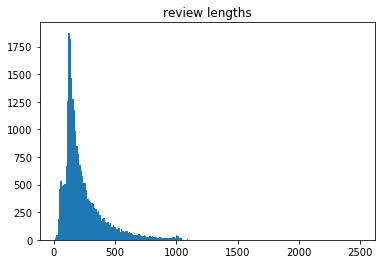

In [8]:
import matplotlib.pyplot as plt

#a = np.hstack((rng.normal(size=1000),rng.normal(loc=5, scale=2, size=1000)))
plt.hist(lens, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("review lengths")
plt.show()

Pad (with zero) or truncate each sentence to make consistent length.

In [13]:
from keras.preprocessing import sequence
seq_len = 500

trn = sequence.pad_sequences(trn, maxlen=seq_len, value=0)
test = sequence.pad_sequences(test, maxlen=seq_len, value=0)

This results in nice rectangular matrices that can be passed to ML algorithms. Reviews shorter than 500 words are pre-padded with zeros, those greater are truncated.

In [19]:
trn.shape

(25000, 500)

## Create simple models

### Single hidden layer NN

The simplest model that tends to give reasonable results is a single hidden layer net. So let's try that. Note that we can't expect to get any useful results by feeding word ids directly into a neural net - so instead we use an embedding to replace them with a vector of 32 (initially random) floats for each word in the vocab.

In [15]:
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout
from keras.optimizers import Adam
import numpy as np
#from keras.

In [21]:
model = Sequential([
    Embedding(5000, 32, input_length=500),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [22]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 500, 32)       160000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 16000)         0           embedding_2[0][0]                
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 100)           1600100     flatten_2[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 100)           0           dense_3[0][0]                    
___________________________________________________________________________________________

In [23]:
model.fit(trn, np.array(labels_train), validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

ValueError: You are passing a target array of shape (25000, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils.np_utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

The [stanford paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) that this dataset is from cites a state of the art accuracy (without unlabelled data) of 0.883. So we're short of that, but on the right track.

### Single conv layer with max pooling

A CNN is likely to work better, since it's designed to take advantage of ordered data. We'll need to use a 1D CNN, since a sequence of words is 1D.

In [27]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [28]:
conv1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [29]:
conv1.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=4, batch_size=64)

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/lock_dir/lock



['nvcc', '-shared', '-O3', '--maxrregcount=32', '-arch=sm_37', '-m64', '-Xcompiler', '-fno-math-errno,-Wno-unused-label,-Wno-unused-variable,-Wno-write-strings,-DCUDA_NDARRAY_CUH=c72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/cuda_ndarray', '-I/home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/cuda_ndarray', '-I/usr/local/cuda/include', '-I/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include', '-I/home/ubuntu/anaconda3/envs/py27/include/python2.7', '-I/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/theano/gof', '-I/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/theano/sandbox/cuda', '-o', '/home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/tmpyOqOLR/3a084fd032db206

1 #include <Python.h>
2 #include <iostream>
3 #include "theano_mod_helper.h"
4 #include "cuda_ndarray.cuh"
5 //////////////////////
6 ////  Support Code
7 //////////////////////
8 
9 
10     namespace {
11     struct __struct_compiled_op_3a084fd032db206a67ca8121a24aa32e {
12         PyObject* __ERROR;
13 
14         PyObject* storage_V3;
15 PyObject* storage_V1;
16         
17 
18         __struct_compiled_op_3a084fd032db206a67ca8121a24aa32e() {
19             // This is only somewhat safe because we:
20             //  1) Are not a virtual class
21             //  2) Do not use any virtual classes in the members
22             //  3) Deal with mostly POD and pointers
23 
24             // If this changes, we would have to revise this, but for
25             // now I am tired of chasing segfaults because
26             // initialization code had an error and some pointer has
27             // a junk value.
28             memset(this, 0, sizeof(*this));
29         }
30         ~__struct

Exception: ('The following error happened while compiling the node', GpuElemwise{RoundHalfToEven}[(0, 0)](GpuElemwise{Composite{scalar_sigmoid((i0 + i1))}}[(0, 0)].0), '\n', 'nvcc return status', 2, 'for cmd', 'nvcc -shared -O3 --maxrregcount=32 -arch=sm_37 -m64 -Xcompiler -fno-math-errno,-Wno-unused-label,-Wno-unused-variable,-Wno-write-strings,-DCUDA_NDARRAY_CUH=c72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden -Xlinker -rpath,/home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/cuda_ndarray -I/home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/cuda_ndarray -I/usr/local/cuda/include -I/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/include -I/home/ubuntu/anaconda3/envs/py27/include/python2.7 -I/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/theano/gof -I/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/theano/sandbox/cuda -o /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/tmpyOqOLR/3a084fd032db206a67ca8121a24aa32e.so mod.cu -L/home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/cuda_ndarray -L/home/ubuntu/anaconda3/envs/py27/lib -lcudart -lcublas -lcuda_ndarray -lpython2.7', '[GpuElemwise{RoundHalfToEven}[(0, 0)](<CudaNdarrayType(float32, matrix)>)]')

That's well past the Stanford paper's accuracy - another win for CNNs!

In [281]:
conv1.save_weights(model_path + 'conv1.h5')

In [46]:
conv1.load_weights(model_path + 'conv1.h5')

## Pre-trained vectors

You may want to look at wordvectors.ipynb before moving on.

In this section, we replicate the previous CNN, but using pre-trained embeddings.

In [23]:
% cd data

/home/ubuntu/Notebooks/fast_ai_course/deeplearning1/nbs/data


In [35]:
import bcolz
import pickle
import re
def load_array(fname):
    return bcolz.open(fname)[:]

In [2]:
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb'),encoding='latin1'),
        pickle.load(open(loc+'_idx.pkl','rb'),encoding='latin1'))

vecs, words, wordidx = load_vectors('/mnt/glove/6B.50d')

NameError: name 'load_array' is not defined

In [1]:
words

NameError: name 'words' is not defined

In [6]:
vecs

array([[ 0.418 ,  0.2497, -0.4124, ..., -0.1841, -0.1151, -0.7858],
       [ 0.0134,  0.2368, -0.169 , ..., -0.5666,  0.0447,  0.3039],
       [ 0.1516,  0.3018, -0.1676, ..., -0.3565,  0.0164,  0.1022],
       ..., 
       [-0.5118,  0.0587,  1.0913, ..., -0.25  , -1.125 ,  1.5863],
       [-0.759 , -0.4743,  0.4737, ...,  0.7895, -0.0141,  0.6448],
       [ 0.0726, -0.5139,  0.4728, ..., -0.1891, -0.5902,  0.5556]], dtype=float32)

The glove word ids and imdb word ids use different indexes. So we create a simple function that creates an embedding matrix using the indexes from imdb, and the embeddings from glove (where they exist).

In [40]:
def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            #src_idx = wordidx[word]
            emb[i] = vecs[wordidx[word]]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [41]:
emb = create_emb()

NameError: name 'idx2word' is not defined

In [27]:
emb.shape

(5000, 50)

In [28]:
vecs.shape

(400000, 50)

We pass our embedding matrix to the Embedding constructor, and set it to non-trainable.

In [24]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2, weights=[emb], trainable=False),
    Dropout(0.25),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

NameError: name 'Sequential' is not defined

In [88]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [23]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

NameError: name 'model' is not defined

We already have beaten our previous model! But let's fine-tune the embedding weights - especially since the words we couldn't find in glove just have random embeddings.

In [91]:
model.layers[0].trainable=True

In [92]:
model.optimizer.lr=1e-4

In [93]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=1, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 4s - loss: 0.2751 - acc: 0.8911 - val_loss: 0.2500 - val_acc: 0.9008


As expected, that's given us a nice little boost. :)

In [94]:
model.save_weights(model_path+'glove50.h5')

## Multi-size CNN

This is an implementation of a multi-size CNN as shown in Ben Bowles' [excellent blog post](https://quid.com/feed/how-quid-uses-deep-learning-with-small-data).

In [23]:
from keras.layers import Merge

We use the functional API to create multiple conv layers of different sizes, and then concatenate them.

In [ ]:
graph_in = Input ((vocab_size, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Merge(mode="concat")(convs) 
graph = Model(graph_in, out) 

In [174]:
emb = create_emb()

We then replace the conv/max-pool layer in our original CNN with the concatenated conv layers.

In [175]:
model = Sequential ([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2, weights=[emb]),
    Dropout (0.2),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.7),
    Dense (1, activation='sigmoid')
    ])

In [176]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [177]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 11s - loss: 0.3997 - acc: 0.8207 - val_loss: 0.3032 - val_acc: 0.8943
Epoch 2/2
25000/25000 [==============================] - 11s - loss: 0.2882 - acc: 0.8832 - val_loss: 0.2646 - val_acc: 0.9029


Interestingly, I found that in this case I got best results when I started the embedding layer as being trainable, and then set it to non-trainable after a couple of epochs. I have no idea why!

In [178]:
model.layers[0].trainable=False

In [179]:
model.optimizer.lr=1e-5

In [180]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 11s - loss: 0.2556 - acc: 0.8949 - val_loss: 0.2534 - val_acc: 0.9024
Epoch 2/2
25000/25000 [==============================] - 11s - loss: 0.2360 - acc: 0.9057 - val_loss: 0.2577 - val_acc: 0.9036


This more complex architecture has given us another boost in accuracy.

## LSTM

We haven't covered this bit yet!

In [79]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, mask_zero=True,
              W_regularizer=l2(1e-6), dropout=0.2),
    LSTM(100, consume_less='gpu'),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_13 (Embedding)         (None, 500, 32)       160064      embedding_input_13[0][0]         
____________________________________________________________________________________________________
lstm_13 (LSTM)                   (None, 100)           53200       embedding_13[0][0]               
____________________________________________________________________________________________________
dense_18 (Dense)                 (None, 1)             101         lstm_13[0][0]                    
Total params: 213365
____________________________________________________________________________________________________


In [80]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=5, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 100s - loss: 0.5007 - acc: 0.7446 - val_loss: 0.3475 - val_acc: 0.8531
Epoch 2/5
25000/25000 [==============================] - 100s - loss: 0.3524 - acc: 0.8507 - val_loss: 0.3602 - val_acc: 0.8453
Epoch 3/5
25000/25000 [==============================] - 99s - loss: 0.3750 - acc: 0.8342 - val_loss: 0.4758 - val_acc: 0.7710
Epoch 4/5
25000/25000 [==============================] - 99s - loss: 0.3238 - acc: 0.8652 - val_loss: 0.3094 - val_acc: 0.8725
Epoch 5/5
25000/25000 [==============================] - 99s - loss: 0.2681 - acc: 0.8920 - val_loss: 0.3018 - val_acc: 0.8776
